# Терешенков Александр БВТ2203. Курсовая работа

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Свои линейные слои

In [ ]:
class MyNormalLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.normal(0, 0.001, size=(in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

In [4]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * (1.0 / in_features**0.5))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

## Свои функции активации

In [5]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.clamp(x, min=0)

In [6]:
class CustomTanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.tanh(x)

## Обучение и тестирование моделей с самописными классами линейных слоев и функций активации

In [7]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self, MyLinear, ActivationFun):
        super(MNISTAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            MyLinear(28 * 28, 128),
            ActivationFun(),
            MyLinear(128, 64),
            ActivationFun(),
            MyLinear(64, 36),
            ActivationFun(),
            MyLinear(36, 18),
            ActivationFun(),
            MyLinear(18, 9)
        )
        self.decoder = nn.Sequential(
            MyLinear(9, 18),
            ActivationFun(),
            MyLinear(18, 36),
            ActivationFun(),
            MyLinear(36, 64),
            ActivationFun(),
            MyLinear(64, 128),
            ActivationFun(),
            MyLinear(128, 28 * 28),
            ActivationFun()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def add_noise(images, mean=0., std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [9]:
def train_denoising_autoencoder(model, train_loader, optimizer, criterion, num_epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):

            data = data.view(data.size(0), -1).to(device)  # [batch_size, 784]

            noisy_data = add_noise(data, std=0.8)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, data)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
    
    return train_losses

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

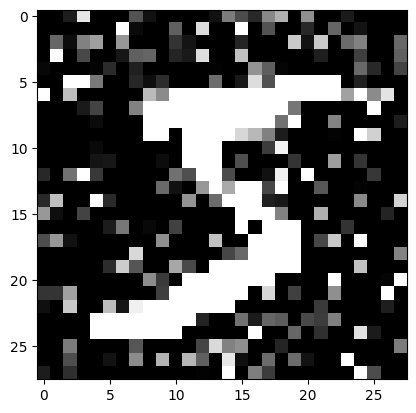

In [11]:
plt.imshow(add_noise(train_dataset[0][0], std=0.8).numpy().squeeze(), cmap="gray")

In [ ]:
model_normal_relu = MNISTAutoEncoder(MyNormalLinear, CustomReLU).to(device)
criterion_normal_relu = nn.MSELoss()
optimizer_normal_relu = optim.Adam(model_normal.parameters(), lr=0.001)

model_reg_relu = MNISTAutoEncoder(MyLinear, CustomReLU).to(device)
criterion_reg_relu = nn.MSELoss()
optimizer_reg_relu = optim.Adam(model_reg.parameters(), lr=0.001)

In [13]:
losses_1 = train_denoising_autoencoder(model_normal, train_loader, optimizer_normal, criterion_normal)

Epoch [1/50], Average Loss: 0.801087
Epoch [2/50], Average Loss: 0.758578
Epoch [3/50], Average Loss: 0.719900
Epoch [4/50], Average Loss: 0.690853
Epoch [5/50], Average Loss: 0.675909
Epoch [6/50], Average Loss: 0.665786
Epoch [7/50], Average Loss: 0.657687
Epoch [8/50], Average Loss: 0.650894
Epoch [9/50], Average Loss: 0.647643
Epoch [10/50], Average Loss: 0.643935
Epoch [11/50], Average Loss: 0.644101
Epoch [12/50], Average Loss: 0.640694
Epoch [13/50], Average Loss: 0.635824
Epoch [14/50], Average Loss: 0.633843
Epoch [15/50], Average Loss: 0.634673
Epoch [16/50], Average Loss: 0.629598
Epoch [17/50], Average Loss: 0.642662
Epoch [18/50], Average Loss: 0.627528
Epoch [19/50], Average Loss: 0.628104
Epoch [20/50], Average Loss: 0.642529
Epoch [21/50], Average Loss: 0.634572
Epoch [22/50], Average Loss: 0.627819
Epoch [23/50], Average Loss: 0.641444
Epoch [24/50], Average Loss: 0.636330
Epoch [25/50], Average Loss: 0.636292
Epoch [26/50], Average Loss: 0.636974
Epoch [27/50], Averag

In [14]:
losses_2 = train_denoising_autoencoder(model_reg, train_loader, optimizer_reg, criterion_reg)

Epoch [1/50], Average Loss: 0.621573
Epoch [2/50], Average Loss: 0.517852
Epoch [3/50], Average Loss: 0.484584
Epoch [4/50], Average Loss: 0.467219
Epoch [5/50], Average Loss: 0.456957
Epoch [6/50], Average Loss: 0.450700
Epoch [7/50], Average Loss: 0.445745
Epoch [8/50], Average Loss: 0.442051
Epoch [9/50], Average Loss: 0.437699
Epoch [10/50], Average Loss: 0.433791
Epoch [11/50], Average Loss: 0.429500
Epoch [12/50], Average Loss: 0.424642
Epoch [13/50], Average Loss: 0.422378
Epoch [14/50], Average Loss: 0.420175
Epoch [15/50], Average Loss: 0.417378
Epoch [16/50], Average Loss: 0.415029
Epoch [17/50], Average Loss: 0.413287
Epoch [18/50], Average Loss: 0.411498
Epoch [19/50], Average Loss: 0.410320
Epoch [20/50], Average Loss: 0.408385
Epoch [21/50], Average Loss: 0.404780
Epoch [22/50], Average Loss: 0.403212
Epoch [23/50], Average Loss: 0.401885
Epoch [24/50], Average Loss: 0.401228
Epoch [25/50], Average Loss: 0.400050
Epoch [26/50], Average Loss: 0.398723
Epoch [27/50], Averag

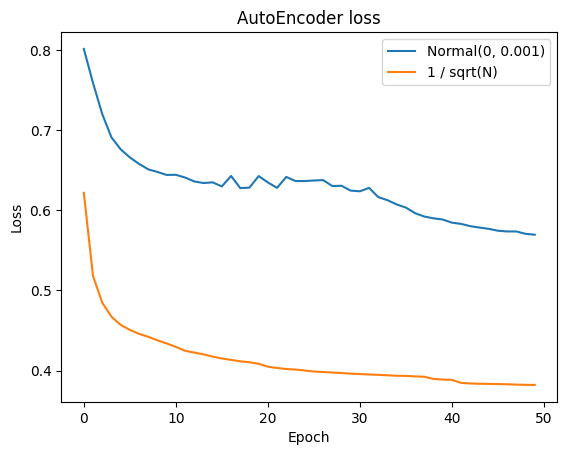

In [28]:
plt.plot(losses_1, label="Normal(0, 0.001)")
plt.plot(losses_2, label="1 / sqrt(N)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("AutoEncoder loss")
plt.show()

In [24]:
def test_model(model_1, model_2):
    model_1.eval()
    model_2.eval()

    for i in range(5):
        noisy_img = add_noise(train_dataset[i][0], std=0.7)
        denoised_img_1 = model_1.decoder(model_1.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))
        denoised_img_2 = model_2.decoder(model_2.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))

        denoised_img_1 = denoised_img_1.view(-1, 1, 28, 28).cpu()
        denoised_img_2 = denoised_img_2.view(-1, 1, 28, 28).cpu()

        plt.figure(figsize=(6, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(noisy_img.numpy().squeeze(), cmap="gray")
        plt.title('Image 1')
        plt.axis('off')


        plt.subplot(1, 3, 2)
        plt.imshow(denoised_img_1.cpu().detach().numpy().squeeze(), "gray")
        plt.title('Image Model 1')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(denoised_img_2.cpu().detach().numpy().squeeze(), "gray")
        plt.title('Image Model 2')
        plt.axis('off')

        plt.tight_layout()

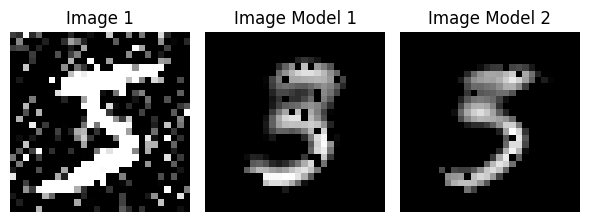

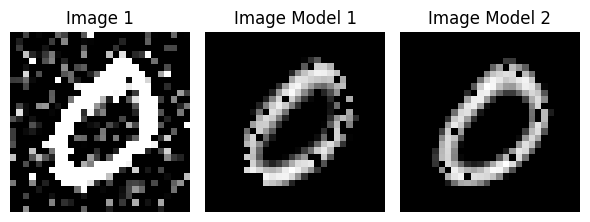

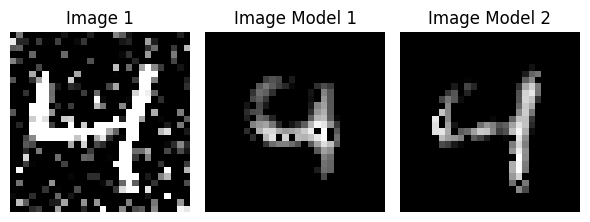

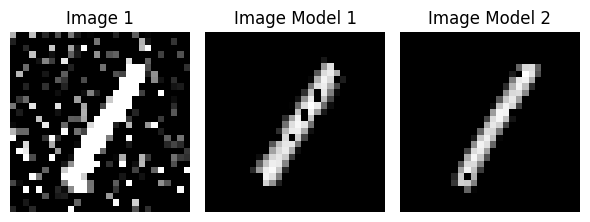

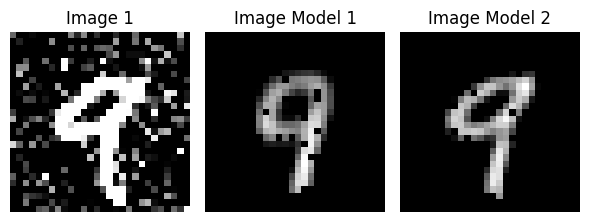

In [25]:
test_model(model_normal, model_reg)